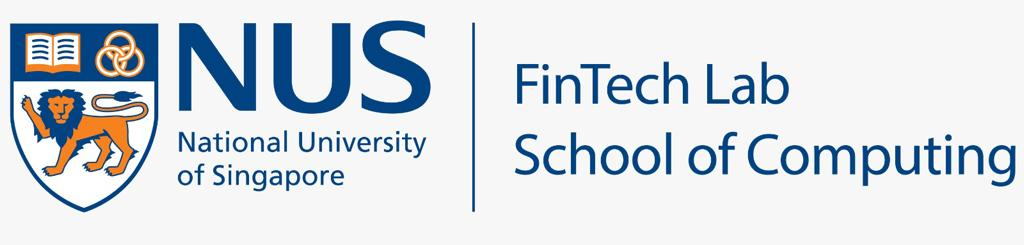

---


# Objective

To use HitBTC APIs to get BTC data and store it in a google sheet.

Algorithm 
1. Write code to calculate Simple Moving Average(SMA) 
2. Display the SMA line through the chart in notebook
3. Write a function to decide the signal based on the chart (Signal: Time to Buy or Sell)
4. Write the buy signals to the Google sheet.
5. Incorporate an Exponential Moving Average, display both signals

## Key Definitions: 

**HitBTC** 

HitBTC is a Bitcoin exchange service that allows users to trade Bitcoins for U.S. Dollars, Euros, or Litecoins as well as retrieve market data.

**Simple Moving Average(SMA)** 

A simple moving average (SMA) is calculated by summing over a fixed number of close prices, and dividing this by the number of prices.
A simple moving average is a technical indicator that can aid in determining if an asset price will continue or if it will reverse a bull or bear trend.

**Moving average crossover**

A crossover occurs when a faster Moving Average (a shorter period moving average) crosses either above or below a slower (i.e. longer period) moving average. A crossover that moves above a slower MA is considered a bullish crossover; one that moves below is considered a bearish crossover.


**Buy and Sell Signals**

When the short term moving average crosses above the long term moving average, this indicates a **buy signal**.

When the short term moving average crosses below the long term moving average, this indicates a **sell signal**.

**Exponential Moving Average**

Exponential moving averages (EMAs) are designed to see price trends over specific time frames, such as 50 or 200 days. Compared to simple moving averages, EMAs give greater weight to recent (more relevant) data.
Computing the EMA involves applying a multiplier to the simple moving average (SMA).

### Import Libraries

In [1]:
#import libraries to save the data from hitBTC to dataframe
import pandas as pd
import requests
import json
import numpy as np
import datetime
import matplotlib.pyplot as plt 

In [2]:
#import libraries for google credentials
import gspread
from google.colab import auth
from oauth2client.client import GoogleCredentials as GC
from gspread_dataframe import set_with_dataframe

### Call HitBTC using APIs

In [3]:
def getDataHitbtc(symbol, period, since):

  url = "https://api.hitbtc.com/api/3/public/candles/"+symbol

  payload = {'period': period,'from':since ,'limit': 1000}

  response = requests.get(url, payload)
  response.text
  data = response.text
  new_data = json.loads(data) 
  # save the data to a dataframe
  df = pd.DataFrame(new_data,columns=['timestamp','open','close','min','max','volume','volumeQuote'])

  # print (df)
  return df

### Authenticating Google sheet

In [4]:
def saveToGS(df) :
  # authenticate
  auth.authenticate_user()
  # Authorise google credentials
  gc = gspread.authorize(GC.get_application_default())
  # create, and save df
  title = 'IS5006_HW2'
  gc.create(title)  # if not exists
  sheet = gc.open(title).sheet1
  set_with_dataframe(sheet, df) 
  # include_index=False, include_column_header=True, resize=False


### Saving initial data for stock ticker ETH/USDT (Ethereum (ETH) to Tether (USDT)) to Google Sheet

**Key Parameters-**
*   Ticker: ETHUSDT
*   Time Period of evaluation: Jan 2020 to Present 
*   Period: Daily







In [5]:
#calling functions to get the data from HitBTC (changes these variables to desired values)
symbol = "ETHUSDT"
since = '01-01-2020'
period = "D1"

#save the data to a dataframe
df_GS = getDataHitbtc(symbol, period, since)
print (df_GS)
#save the dataframe to google sheets
saveToGS(df_GS)


                    timestamp      open  ...       volume volumeQuote
0    2022-02-13T00:00:00.000Z  2919.146  ...   72276.2674         NaN
1    2022-02-12T00:00:00.000Z  2928.440  ...  125439.2722         NaN
2    2022-02-11T00:00:00.000Z  3073.001  ...  192971.4440         NaN
3    2022-02-10T00:00:00.000Z  3243.679  ...  189367.2834         NaN
4    2022-02-09T00:00:00.000Z  3117.615  ...  151897.2679         NaN
..                        ...       ...  ...          ...         ...
770  2020-01-05T00:00:00.000Z    134.21  ...  234735.3492         NaN
771  2020-01-04T00:00:00.000Z   134.415  ...  365857.7254         NaN
772  2020-01-03T00:00:00.000Z   127.153  ...  365424.1440         NaN
773  2020-01-02T00:00:00.000Z   130.734  ...  219423.9557         NaN
774  2020-01-01T00:00:00.000Z   129.215  ...  223448.2926         NaN

[775 rows x 7 columns]


### Create a new dataframe and apply below transformations to rectify datatypes and timestamp.





In [6]:
#create an empty pandas dataframe 
df_ethusdt= pd.DataFrame()

#convert timestamp to datetime and store in new dataframe 
df_ethusdt["timestamp"] = pd.to_datetime(df_GS["timestamp"]).dt.date

#convert datatype to numeric and store in new dataframe 
df_ethusdt["open"] = pd.to_numeric(df_GS["open"])
df_ethusdt["close"] = pd.to_numeric(df_GS["close"])
df_ethusdt["min"] = pd.to_numeric(df_GS["min"])
df_ethusdt["max"] = pd.to_numeric(df_GS["max"])
df_ethusdt["volume"] = pd.to_numeric(df_GS["volume"])

#Set the date as the index
df_ethusdt.set_index('timestamp', inplace = True)

#View first few rows of dataframe
df_ethusdt.head()

,open,close,min,max,volume
timestamp,,,,,
2022-02-13,2919.146,2892.340,2868.000,2954.000,72276.2674
2022-02-12,2928.440,2914.653,2856.497,2983.966,125439.2722
2022-02-11,3073.001,2928.447,2879.786,3139.257,192971.4440
2022-02-10,3243.679,3071.413,3058.797,3285.576,189367.2834
2022-02-09,3117.615,3243.708,3055.000,3270.581,151897.2679


### Plot of general price variation of the closing price for the given period

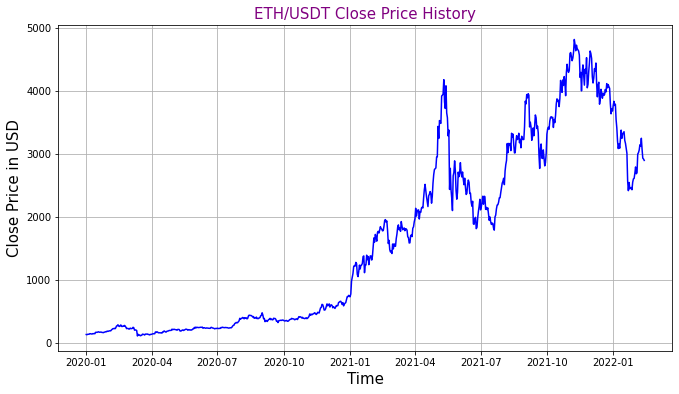

In [7]:
#Visually show the close price for given time period 
plt.figure(figsize=(11,6))
plt.title('ETH/USDT Close Price History', color='purple',fontsize=15)
plt.plot(df_ethusdt['close'], color='b')
plt.xlabel('Time',fontsize=15)
plt.ylabel('Close Price in USD',fontsize=15)
plt.grid()
plt.show()

### Calculate Simple Moving Average 

The formula for SMA is:

\begin{aligned} &\text{SMA}=\dfrac{A_1 + A_2 + ... + A_n}{n} \\ &\textbf{where:}\\ &A_n=\text{the price of an asset at period } n\\ &n=\text{the number of total periods}\\ \end{aligned} 
​
  
Generic function to calculate SMA using pandas.DataFrame.rolling() function.
​


In [8]:
#Create a function to calculate Simple Moving Average (SMA)
def SMA(data, period, column ='close'):
  return data[column].rolling(window=period).mean()

###Use SMA function to calculate 20-days(short) and 50-days(long) Simple Moving Average(SMA) and store it in column SMA20 and SMA50 receptively.

In [9]:
#Create two new columns to store the 20 day and 50 day SMA
df_ethusdt['SMA20']=SMA(df_ethusdt,20)
df_ethusdt['SMA50']=SMA(df_ethusdt,50)
df_ethusdt = df_ethusdt[df_ethusdt.index > datetime.date(2019, 12, 31)]
df_ethusdt.tail()

,open,close,min,max,volume,SMA20,SMA50
timestamp,,,,,,,
2020-01-05,134.210,135.400,134.210,138.169,234735.3492,155.78280,196.83996
2020-01-04,134.415,134.196,132.531,135.828,365857.7254,154.35860,194.03548
2020-01-03,127.153,134.356,125.800,135.144,365424.1440,152.93560,191.49026
2020-01-02,130.734,127.170,126.428,130.756,219423.9557,150.88900,188.72868
2020-01-01,129.215,130.703,128.728,132.977,223448.2926,148.95225,186.19312


### Plot of general price variation of the closing price with SMA for the given period

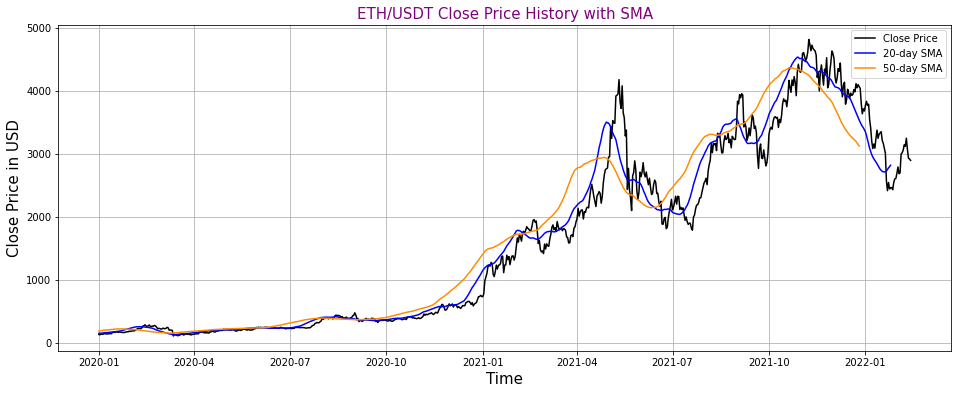

In [10]:
#Visually show the close price with SMA
plt.figure(figsize=(16,6))
plt.title('ETH/USDT Close Price History with SMA', color='purple',fontsize=15)
plt.plot(df_ethusdt['close'], color ='k', label='Close Price')
plt.plot(df_ethusdt['SMA20'], color ='b',label='20-day SMA')
plt.plot(df_ethusdt['SMA50'], color ='darkorange', label='50-day SMA')
plt.xlabel('Time',fontsize=15)
plt.ylabel('Close Price in USD',fontsize=15)
plt.grid()
plt.legend()
plt.show()

#### Understanding the plot

1. Faster moving average(20 day SMA) is represented by the blue line (20 day SMA)
2. Slower moving average(50 day SMA) is represented by the orange line (50 day SMA)
3. The closing price is represented by the black line.
4. Simple moving averages are smoothed version of actual prices that lag by a set amount of time.
5. The short-term moving average is very similar to the current price.
6. The long-term moving average has a longer lag than the short-term moving average and closely follows the actual price curve.


### Calcule when to buy and sell using simple moving crossover  

**Signal 1**:  If 20-day SMA is greater than 50-day SMA then set Signal value as 1

**Signal 0**:  If 50-day SMA is greater than 20-day SMA then set Signal value as 0

**Postion = 1** The Signal has changed from 0 to 1 meaning a short-term(faster) moving average has crossed above the long-term(slower) moving average. This triggers a **buy call**. 

**Position = -1** The Signal has changed from 1 to 0 meaning a short-term(faster) moving average has crossed below the long-term(slower) moving average. This triggers a **sell call**



In [11]:
#Get the buy and sell signals
df_ethusdt['Signal']=np.where(df_ethusdt['SMA20'] > df_ethusdt['SMA50'],1,0) # if SMA 20 > SMA 50 then Signal =1 else Singnal = 0
df_ethusdt['Position']=df_ethusdt['Signal'].diff()
df_ethusdt['Buy']=np.where(df_ethusdt['Position']==1,df_ethusdt['close'],np.NAN)
df_ethusdt['Sell']=np.where(df_ethusdt['Position'] == -1,df_ethusdt['close'],np.NAN)
df_ethusdt[df_ethusdt['Position']!=0].head()

,open,close,min,max,volume,SMA20,SMA50,Signal,Position,Buy,Sell
timestamp,,,,,,,,,,,
2022-02-13,2919.146,2892.340,2868.000,2954.000,72276.2674,NaN,NaN,0,NaN,NaN,NaN
2021-12-26,4095.284,4062.604,4005.000,4104.775,69932.5280,3533.34790,3121.58734,1,1.0,4062.604,NaN
2021-10-21,4160.969,4054.552,4016.500,4371.427,141676.3042,4352.50680,4358.20616,0,-1.0,NaN,4054.552
2021-09-02,3827.858,3788.000,3722.846,3838.800,363061.1160,3476.08715,3455.75374,1,1.0,3788.000,NaN
2021-08-14,3322.998,3264.233,3205.521,3332.628,304711.9234,3275.39190,3293.24700,0,-1.0,NaN,3264.233


### Plot of closing price variation with 20-day SMA and 50-day SMA

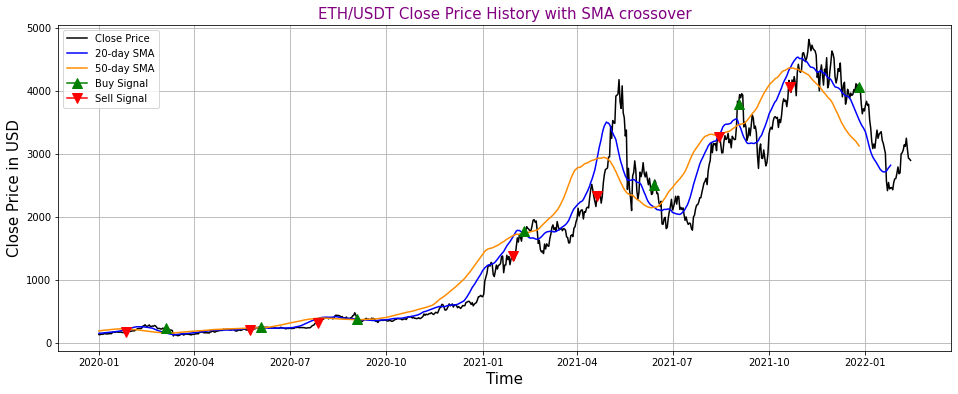

In [12]:
#Visually show the close price with SMA and Buy and Sell Signals
plt.figure(figsize=(16,6))
plt.title('ETH/USDT Close Price History with SMA crossover', color='purple', fontsize=15)
plt.plot(df_ethusdt['close'], color ='k', label='Close Price')
plt.plot(df_ethusdt['SMA20'], color ='b',label='20-day SMA')
plt.plot(df_ethusdt['SMA50'], color ='darkorange', label='50-day SMA')
plt.plot(df_ethusdt.index, df_ethusdt['Buy'], marker='^',markersize = 10, color='g',label='Buy Signal')
plt.plot(df_ethusdt.index, df_ethusdt['Sell'],marker='v',markersize = 10, color='r',label='Sell Signal')
plt.xlabel('Time',fontsize=15)
plt.ylabel('Close Price in USD',fontsize=15)
plt.grid()
plt.legend()
plt.show()

#### Understanding the plot
1. Faster moving average(20 day SMA) is represented by the blue line (20 day SMA)
2. Slower moving average(50 day SMA) is represented by the orange line (50 day SMA)
3. The closing price is represented by the black line.
4. Simple moving averages are smoothed version of actual prices that lag by a set amount of time.
5. The short-term moving average is very similar to the current price.
6. The long-term moving average has a longer lag than the short-term moving average and closely follows the actual price curve.
7.   A signal to buy (as represented by green up-triangle) is triggered when the fast moving average crosses above the slow moving average. This shows a shift in trend i.e. the average price over last 20 days has risen above the average price of past 50 days
8.   A signal to sell(as represented by red down-triangle) is triggered when the fast moving average crosses below the slow moving average indicating that the average price in last 20 days has fallen below the average price of the last 50 days



### Calculate Exponential Moving Average 

The EMA is calculated as:

EMA [today] = (α x Price [today] ) + ((1 — α) x EMA [yesterday] )

Where:

α = 2/(N + 1)

N = the length of the window (moving average period)

EMA [today] = the current EMA value

Price [today] = the current closing price

EMA [yesterday] = the previous EMA value
​


Generic function to calculate EMA using pandas.DataFrame.ewm() function.

In [13]:
#Create a function to calculate Exponential Moving Average (SMA)
def EMA(data, period, column ='close'):
  return data[column].ewm(span=period,adjust = False).mean()

### Use EMA function to calculate 20-days(short) and 50-days(long) Simple Moving Average(SMA) and store it in column EMA20 and EMA50 receptively.

In [14]:
df_ethusdt['EMA20']=EMA(df_ethusdt,20)
df_ethusdt['EMA50']=EMA(df_ethusdt,50)

### Calcule when to buy and sell using Exponential moving crossover  

In [15]:
#Get the buy and sell signals
df_ethusdt['Signal']=np.where(df_ethusdt['EMA20'] > df_ethusdt['EMA50'],1,0)
df_ethusdt['Position']=df_ethusdt['Signal'].diff()

df_ethusdt['Buy']=np.where(df_ethusdt['Position']==1,df_ethusdt['close'],np.NAN)
df_ethusdt['Sell']=np.where(df_ethusdt['Position'] == -1,df_ethusdt['close'],np.NAN)

df_ethusdt[df_ethusdt['Position']!=0].head()

,open,close,min,max,volume,SMA20,SMA50,Signal,Position,Buy,Sell,EMA20,EMA50
timestamp,,,,,,,,,,,,,
2022-02-13,2919.146,2892.340,2868.000,2954.000,72276.2674,NaN,NaN,0,NaN,NaN,NaN,2892.340000,2892.340000
2022-02-12,2928.440,2914.653,2856.497,2983.966,125439.2722,NaN,NaN,1,1.0,2914.653,NaN,2894.465048,2893.215020
2022-01-31,2602.450,2687.517,2477.746,2706.629,185975.9290,NaN,NaN,0,-1.0,NaN,2687.517,2898.356759,2907.651347
2022-01-16,3326.441,3347.602,3273.286,3392.205,73851.3586,2735.4922,NaN,1,1.0,3347.602,NaN,2855.318732,2845.527232
2021-10-19,3748.795,3876.428,3733.153,3885.631,183027.0422,4277.2942,4348.14882,0,-1.0,NaN,3876.428,4213.731810,4218.695426


### Plot of closing price variation with 20-day EMA and 50-day EMA

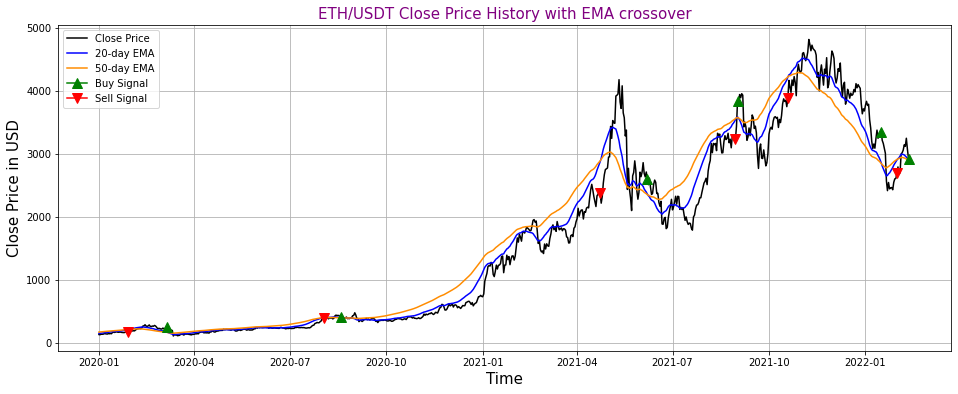

In [16]:
#Visually show the close price with EMA and Buy and Sell Signals
plt.figure(figsize=(16,6))
plt.title('ETH/USDT Close Price History with EMA crossover', color='purple', fontsize=15)
plt.plot(df_ethusdt['close'], color ='k', label='Close Price')
plt.plot(df_ethusdt['EMA20'], color ='b',label='20-day EMA')
plt.plot(df_ethusdt['EMA50'], color ='darkorange', label='50-day EMA')
plt.plot(df_ethusdt.index, df_ethusdt['Buy'], marker='^',markersize = 10, color='g',label='Buy Signal')
plt.plot(df_ethusdt.index, df_ethusdt['Sell'],marker='v',markersize = 10, color='r',label='Sell Signal')
plt.xlabel('Time',fontsize=15)
plt.ylabel('Close Price in USD',fontsize=15)
plt.grid()
plt.legend()
plt.show()

#### Understanding the plot


1.  Faster moving average(20 day EMA) is represented by the blue line (20 day EMA)
2. Slower moving average(50 day EMA) is represented by the orange line (50 day EMA)
3. The closing price is represented by the black line.
4. The exponentially smoothed average assigns a greater weight to the more recent data. Therefore, it is a weighted moving average
5.   The short-term moving average closely resembles the actual price
6.   The long-term moving average has comparatively more lag and loosely resembles the actual price curve

In [17]:
#Saving crossover details in google sheet to derive conclusion
saveToGS(df_ethusdt)

## Conclusion

The returns created by EMA buy-sell trends appear to be relatively comparable to those generated by SMAs, however there are some distinctions.
This is because exponential moving averages weight the most recent periods more heavily. As a result, they are more dependable than SMAs because they provide a better depiction of the asset's recent performance.
As a result, we can state that the EMA crossover strategy outperforms the SMA in some respects, but there is no definitive outcome.

## References

https://towardsdatascience.com/making-a-trade-call-using-simple-moving-average-sma-crossover-strategy-python-implementation-29963326da7a